## Design and Hedging of a Structured Product

### Experiment 02: Valuation

### Bates Model Overview

---

#### **What Is the Bates Model?**

The Bates model extends the Heston stochastic volatility model by incorporating **jumps** in the asset price. The risk-neutral dynamics are:

$$
\frac{dS_t}{S_{t^-}} = (r - \lambda \mathbb{E}[J - 1])\,dt + \sqrt{v_t}\,dW_t^S + (J - 1)\,dN_t
$$

$$
dv_t = \kappa(\theta - v_t)\,dt + \sigma\sqrt{v_t}\,dW_t^v
$$

**Where:**

- $S_t$: stock price  
- $v_t$: instantaneous variance  
- $r$: risk-free rate  
- $W_t^S, W_t^v$: correlated Brownian motions ($\rho$)  
- $N_t$: Poisson jump process with intensity $\lambda$  
- $J$: jump size, usually lognormally distributed

---

#### **Model Intuition**

| Component                     | Description                                          |
|------------------------------|------------------------------------------------------|
| Stochastic volatility (Heston) | Captures volatility clustering via $v_t$             |
| Jumps (Merton-type)          | Captures rare, large price moves                    |
| Correlation $\rho$           | Links volatility shocks with price shocks           |

---

#### **Why Use the Bates Model?**

- Captures **fat tails** and **skewness** in returns  
- Better fits **implied volatility surfaces**  
- Essential for pricing **exotic products** like Bonus Certificates

---

#### **Model Parameters**

| Parameter      | Meaning                                 |
|----------------|-----------------------------------------|
| $v_0$          | Initial variance                        |
| $\kappa$       | Mean reversion speed of variance        |
| $\theta$       | Long-run variance                       |
| $\sigma$       | Volatility of volatility                |
| $\rho$         | Correlation between asset and variance  |
| $\lambda$      | Jump intensity                          |
| $\mu_J$        | Mean of log jump size                   |
| $\sigma_J$     | Std. dev. of log jump size              |

---

#### **Characteristic Function $\phi(u)$**

$$
\phi(u) = \exp\left\{ iux + C(u,T) + D(u,T)v_0 + T\lambda \left(e^{iu\mu_J - \frac{1}{2}u^2\sigma_J^2} - 1\right) \right\}
$$

With:

$$
d = \sqrt{(\rho \sigma iu - \kappa)^2 + \sigma^2 (iu + u^2)}
$$

$$
g = \frac{\kappa - \rho \sigma iu - d}{\kappa - \rho \sigma iu + d}
$$

$$
C(u,T) = \frac{\kappa\theta}{\sigma^2}
\left[(\kappa - \rho \sigma iu - d)T - 2\log\left(\frac{1 - g e^{-dT}}{1 - g}\right)\right]
$$

$$
D(u,T) = \frac{\kappa - \rho \sigma iu - d}{\sigma^2} \cdot \left( \frac{1 - e^{-dT}}{1 - g e^{-dT}} \right)
$$


In [1]:
import numpy as np
import pandas as pd
from numpy.fft import fft
from scipy.interpolate import interp1d
from scipy.stats import norm
from scipy.optimize import minimize
import matplotlib.pyplot as plt

In [2]:
class Valuation:
    def __init__(
        self,
        S0,
        r,
        T,
        v0,
        kappa,
        theta,
        sigma,
        rho,
        lamb,
        mu_j,
        sigma_j
    ):
        """
        Description
            Initialize Bates model parameters.

        Args:
            S0 (float): Spot price.
            r (float): Risk-free rate.
            T (float): Time to maturity (in years).
            v0 (float): Initial variance.
            kappa (float): Mean reversion rate.
            theta (float): Long-run variance.
            sigma (float): Volatility of volatility.
            rho (float): Correlation between stock and variance.
            lamb (float): Jump intensity (λ).
            mu_j (float): Mean of log jump size.
            sigma_j (float): Std. dev. of log jump size.
        """
        self.S0 = S0
        self.r = r
        self.T = T
        self.v0 = v0
        self.kappa = kappa
        self.theta = theta
        self.sigma = sigma
        self.rho = rho
        self.lamb = lamb
        self.mu_j = mu_j
        self.sigma_j = sigma_j

    def bs_characteristic_function(self, u, sigma):
        """
        Black Scholes Characteristic function for Sanity Check.

        Args:
            u (np.ndarray or float): Fourier variable.
            sigma (float): Representative volatility.

        Returns:
            float: Black Scholes Characteristic function value.
        """
        i = 1j
        return np.exp(i * u * np.log(self.S0) + 
                      (i * u * (self.r - 0.5 * sigma ** 2) - 
                       0.5 * u ** 2 * sigma ** 2) * self.T)

    def bates_characteristic_function(self, u):
        """
        Description
            Characteristic function φ(u) of log(S_T) under the Bates model.

        Args:
            u (np.ndarray or float): Fourier variable.

        Returns:
            np.ndarray or float: Characteristic function value at u.
        """
        i = 1j
        x = np.log(self.S0)

        d = np.sqrt(
            (self.rho * self.sigma * i * u - self.kappa) ** 2
            + self.sigma ** 2 * (i * u + u ** 2)
        )

        g = (self.kappa - self.rho * self.sigma * i * u - d) / (
            self.kappa - self.rho * self.sigma * i * u + d
        )

        C = (
            self.kappa * self.theta / self.sigma ** 2
            * ((self.kappa - self.rho * self.sigma * i * u - d) * self.T
               - 2 * np.log((1 - g * np.exp(-d * self.T)) / (1 - g)))
        )

        D = (
            (self.kappa - self.rho * self.sigma * i * u - d)
            / self.sigma ** 2
            * ((1 - np.exp(-d * self.T)) / (1 - g * np.exp(-d * self.T)))
        )

        jump_term = self.lamb * self.T * (
            np.exp(i * u * self.mu_j - 0.5 * self.sigma_j ** 2 * u ** 2) - 1
        )

        return np.exp(i * u * x + C + D * self.v0 + jump_term)

    def carr_madan_price(self, alpha=1.5, N=4096, eta=0.25):
        """
        Description
            Compute option prices using Carr-Madan method with FFT.

        Args:
            alpha (float): Dampening factor.
            N (int): Number of FFT points (must be power of 2).
            eta (float): Integration grid spacing.

        Returns:
            tuple: (strikes array, call prices array)
        """
        i = 1j
        lamb = 2 * np.pi / (N * eta)
        b = N * lamb / 2

        u = np.arange(N) * eta
        ku = -b + lamb * np.arange(N)

        phi = self.bates_characteristic_function(u - (alpha + 1) * i)
        # Black Scholes for Sanity Check.
        #phi = self.bs_characteristic_function(u - (alpha + 1) * i, sigma=0.25)
        psi = (
            np.exp(-self.r * self.T)
            * phi
            / (alpha ** 2 + alpha - u ** 2 + i * (2 * alpha + 1) * u)
        )

        # Construct Simpson's weights
        simpson_weights = np.ones(N)
        simpson_weights[1:N-1:2] = 4
        simpson_weights[2:N-1:2] = 2
        simpson_weights *= eta / 3

        # Apply Simpson's weights to the input
        fft_input = np.exp(i * b * u) * psi * simpson_weights
        
        fft_output = fft(fft_input).real

        call_prices = (np.exp(-alpha * ku) / np.pi) * fft_output
        strikes = np.exp(ku)

        return strikes, call_prices

    def interpolate_call_price(self, K_target):
        """
        Description
            Interpolate the call price at a specific strike using Carr-Madan FFT.

        Args:
            K_target (float): Strike price.

        Returns:
            float: Interpolated call price.
        """
        strikes, prices = self.carr_madan_price()
        try:
            interpolator = interp1d(
                strikes,
                prices,
                kind="cubic",
                bounds_error=True  # prevent silent extrapolation
            )
            return interpolator(K_target)

        except ValueError as e:
            print(f"[Warning] Strike {K_target} is outside interpolation range.")
            raise e

In [3]:
# Load from CSV
spot_df = pd.read_csv("../data/spot_price_ref_date_cost.csv")

# Extract the spot price (assume first row if only one date)
S0 = spot_df.loc[0, "spot_price_ref_date"]
print("Spot Price:",S0)
ref_date = spot_df.loc[0, "ref_date"]

Spot Price: 954.4000244140624


In [4]:
val = Valuation(
    S0=S0,           # loaded from CSV
    r=0.04,          # risk-free rate
    T=0.25,          # 3 months to maturity
    v0=0.04,         # initial variance
    kappa=2.0,       # mean reversion speed
    theta=0.04,      # long-term variance
    sigma=0.3,       # vol of vol
    rho=-0.5,        # correlation
    lamb=0.2,        # jump intensity
    mu_j=-0.1,       # mean jump size
    sigma_j=0.2      # jump std dev
)

In [5]:
call_price_950 = val.interpolate_call_price(K_target=950)
print(f"Call price at K=950: {call_price_950:.4f}")

Call price at K=950: 39.7669


#### Let's check call price from black scholes for sanity check

In [6]:
def black_scholes_price(K, T, S_0, r_f, sigma, dividend_yield):
    """
    This function returns the Call or Put Price using the
    Black-Scholes Formula.

    Args:
        K (float): Strike Price, the price at which the option
                    can be exercised.
        T (float): Time to maturity, the time when the option
                    may be exercised.
        S_0 (float): Initial price of the underlying stock.
        r_f (float): Risk-Free rate, government bond return
                    rates etc.
        sigma (float): Volatility, of the market, assumed
                    to be constant in the Black-Scholes
                    Model.
        dividend_yield (float): No Idea, like how much dividiend is paid out?

    Returns:
        C (float): Call Price
        P (float): Put Price
    """
    # d_1 used to calculate N_d1, the z-score (fed into std normal later) for
    # expected log return of the asset being above the strike at time T,
    # under risk neutral dynamics.
    d_1 = (np.log(S_0 / K) + (r_f - dividend_yield + sigma**2 / 2) * T) / (sigma * np.sqrt(T))

    # d_2 used to calculate N_d2, the z-scroe for the actual probability that
    # the model will expire in the money, under risk-neutral measure.
    d_2 = d_1 - (sigma * np.sqrt(T))

    # N_d1 and N_d2 are the cumulative probability of d_1 and d_2 from a Std. Normal dist.
    N_d1 = norm.cdf(d_1)
    N_d2 = norm.cdf(d_2)

    C = ( (S_0 * np.exp(-dividend_yield * T) * N_d1) - 
         (K * np.exp(-r_f * T) * N_d2) )
    
    # Put price derived with Put-Call Parity
    P = ( (np.exp(-r_f * T) * K) - (np.exp(-dividend_yield * T) * S_0) + C )

    return C,P

In [7]:
# Inputs
K = 950                  # Strike price
T = 0.25                 # 3 months
S0 = S0             # Spot price from your CSV
r = 0.04                 # Annual risk-free rate
sigma = 0.25             # Assume constant vol for now
q = 0.008                # Dividend yield (e.g. 0.8% for Costco, adjust if needed)

# Call the function
call_price, put_price = black_scholes_price(K, T, S0, r, sigma, q)

print(f"Black-Scholes Call Price at K={K}: {call_price:.2f} USD")
print(f"Black-Scholes Put Price at K={K}: {put_price:.2f} USD")


Black-Scholes Call Price at K=950: 53.38 USD
Black-Scholes Put Price at K=950: 41.44 USD


#### Let's do some calibration with clen call and put data from 01 April 2025

In [ ]:
class Calibration(Valuation):
    def __init__(self, *args, **kwargs):
        """
        Inherits all attributes from Valuation.
        """
        super().__init__(*args, **kwargs)

    def calibrate_to_market(self, clean_calls_df, initial_guess, bounds):
        """
        Description
            Calibrate Bates model parameters to market call prices.

        Args:
            clean_calls_df (pd.DataFrame): DataFrame with 'strike' and 'mid' columns.
            initial_guess (list): Initial parameter guess in order:
                [v0, kappa, theta, sigma, rho, lamb, mu_j, sigma_j]
            bounds (list of tuples): Bounds for each parameter.

        Returns:
            dict: Optimized parameters, loss value, and success flag.
        """
        strikes = clean_calls_df["strike"].values
        market_prices = clean_calls_df["mid"].values

        def objective(params):
            self.v0, self.kappa, self.theta, self.sigma, self.rho, self.lamb, self.mu_j, self.sigma_j = params
            model_prices = []
            for K in strikes:
                try:
                    model_price = self.interpolate_call_price(K)
                except Exception:
                    model_price = np.nan
                model_prices.append(model_price)

            model_prices = np.array(model_prices)
            mask = ~np.isnan(model_prices)
            error = model_prices[mask] - market_prices[mask]
            return np.sum(error ** 2)

        result = minimize(
            objective,
            x0=initial_guess,
            bounds=bounds,
            method='L-BFGS-B'
        )

        # Update instance if successful
        if result.success:
            self.v0, self.kappa, self.theta, self.sigma, self.rho, self.lamb, self.mu_j, self.sigma_j = result.x

        return {
            "optimized_params": result.x,
            "loss": result.fun,
            "success": result.success,
            "message": result.message
        }
    
    def plot_calibrated_vs_market(self, clean_calls_df):
        """
        Plot model-calibrated call prices vs market prices.

        Args:
            clean_calls_df (pd.DataFrame): DataFrame with 'strike' and 'mid' columns.
        """
        strikes = clean_calls_df["strike"].values
        market_prices = clean_calls_df["mid"].values
        model_prices = []

        for K in strikes:
            try:
                price = self.interpolate_call_price(K)
            except Exception:
                price = np.nan
            model_prices.append(price)

        model_prices = np.array(model_prices)

        plt.figure(figsize=(10, 6))
        plt.plot(strikes, market_prices, 'o', label="Market", color="steelblue", alpha=0.7)
        plt.plot(strikes, model_prices, 'r*', label="Bates (Calibrated)", markersize=6)

        plt.xlabel("Strike Price (K)")
        plt.ylabel("Call Price")
        plt.title("Bates Model Calibration: Market vs Calibrated Prices")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

In [9]:
calls_df  = pd.read_csv('../data/calls_data_cost.csv')
puts_df = pd.read_csv('../data/puts_data_cost.csv')
print("Shape calls_df:",calls_df.shape)
print("Shape puts_df:",puts_df.shape)

Shape calls_df: (180, 18)
Shape puts_df: (169, 18)


In [10]:
clean_calls_df = calls_df[calls_df['is_clean']]
clean_puts_df = puts_df[puts_df['is_clean']]
print("Shape clean_calls_df:",clean_calls_df.shape)
print("Shape clean_puts_df:",clean_puts_df.shape)

Shape clean_calls_df: (16, 18)
Shape clean_puts_df: (22, 18)


In [11]:
# === Initial parameter guesses for Bates model ===

# Volatility dynamics
v0_init       = 0.04   # Initial variance
kappa_init    = 2.0    # Speed of mean reversion
theta_init    = 0.04   # Long-run variance
sigma_init    = 0.3    # Volatility of volatility
rho_init      = -0.5   # Correlation (negative, as typically observed)

# Jump component
lambda_init   = 0.2    # Jump intensity (avg. # of jumps per year)
mu_j_init     = -0.1   # Mean of jump size (in log-space)
sigma_j_init  = 0.2    # Volatility of jump size

In [12]:
# Group into a list
initial_guess = [
    v0_init,
    kappa_init,
    theta_init,
    sigma_init,
    rho_init,
    lambda_init,
    mu_j_init,
    sigma_j_init
]

# Parameter bounds for optimizer
bounds = [
    (1e-4, 1.0),    # v0
    (0.1, 5.0),     # kappa
    (1e-4, 1.0),    # theta
    (0.05, 1.0),    # sigma
    (-0.99, 0.0),   # rho
    (0.0, 1.0),     # lambda
    (-0.5, 0.0),    # mu_j
    (1e-4, 1.0)     # sigma_j
]


In [13]:
calibrator = Calibration(S0, r, T, *initial_guess)

result = calibrator.calibrate_to_market(
    clean_calls_df=clean_calls_df,
    initial_guess=initial_guess,
    bounds=bounds
)

print("Success:", result["success"])
print("Final loss:", result["loss"])
print("Optimized θ:", result["optimized_params"])

Success: True
Final loss: 9413.701232739155
Optimized θ: [ 0.17193665  1.50377286  0.00548541  0.74934443 -0.99        0.17925112
  0.          0.23526476]


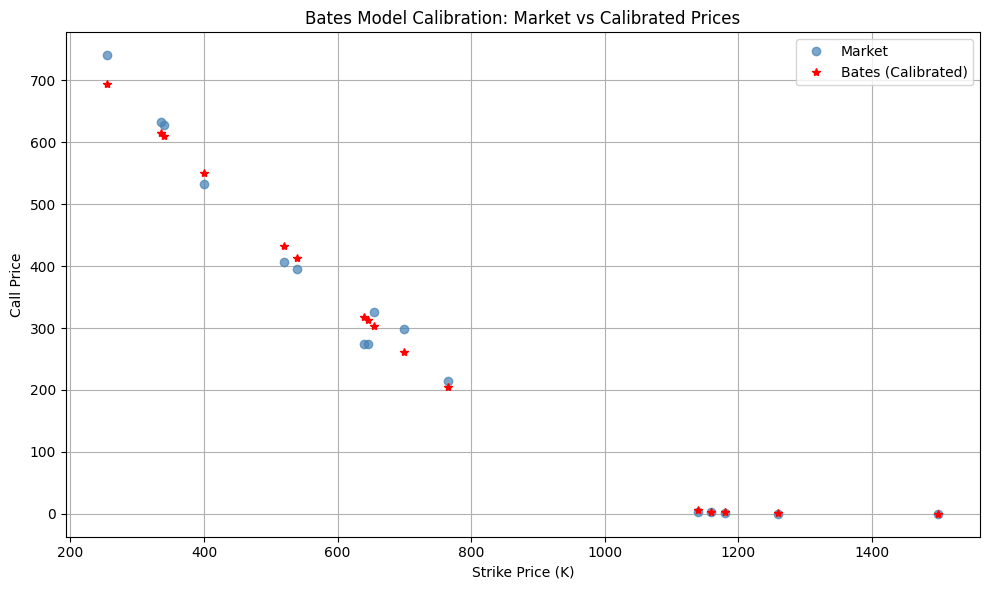

In [14]:
calibrator.plot_calibrated_vs_market(clean_calls_df)

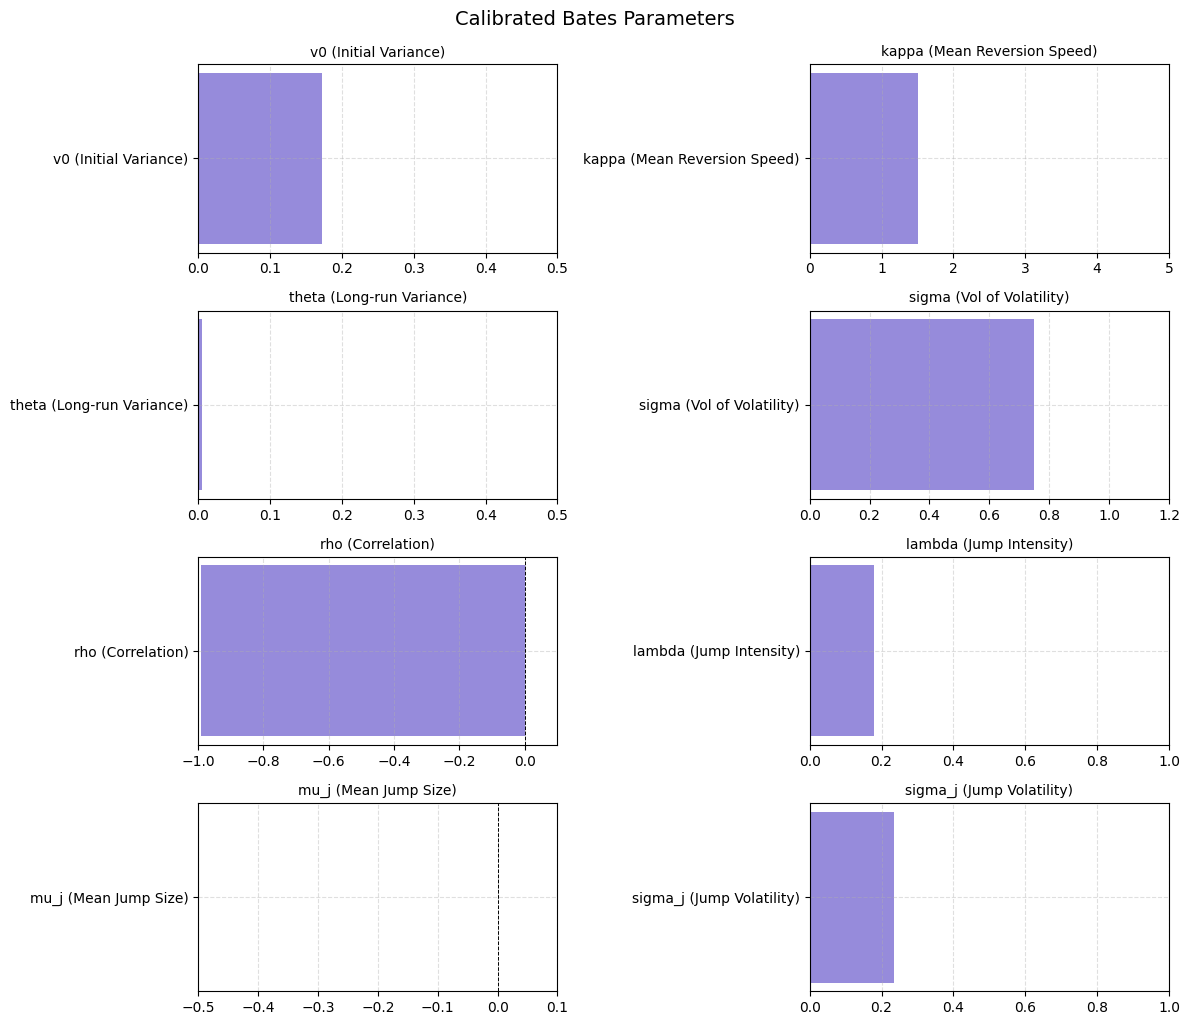